# Package Imports

In [74]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import geopy.distance
import math

# SKLearn package imports
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA

from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, balanced_accuracy_score

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression

# Data Ingestion

In [2]:
# main data
receipt_df = pd.read_excel('/Users/joopark1/Desktop/Numerator/data.xlsx')
# basket timestemps
basket_time = pd.read_csv('/Users/joopark1/Desktop/Numerator/basket_txn_dates.csv', parse_dates = [1,2])
# zip-based lat/long matchtable for user homes
geo_mt = pd.read_csv('/Users/joopark1/Desktop/Numerator/us-zip-code-latitude-and-longitude.csv')

# EDA

### base data

In [3]:
# preview
receipt_df.head()
receipt_df.describe(include = 'all')
receipt_df.dtypes
## we need to change some data types for columns
## we need to drop uniform and superfluous features to have minimal base dataset to work with

,user_id,basket_id,banner_name,retailer_name,channel_name,parent_channel_name,user_geo_postal_code,user_geo_city,user_geo_rural_code,user_geo_state,user_geo_census_region,user_geo_census_division,store_geo_store_id,store_geo_store_name,store_geo_latitude,store_geo_longitude,store_geo_state,store_geo_city,payment_method,trip_type,basket_total_dollars,basket_total_units,salestax,transcribed,transcription_level,payment_id,last_update,user_demo_ethnicity,user_demo_age,user_demo_education,user_demo_employment,user_demo_gender,user_demo_has_children_under17,user_demo_household_size,user_demo_income,user_demo_marital_status,trip_rating,kids_present_on_trip,adult_genders_on_trip,other_banners_in_shopping_trip,other_retailers_in_shopping_trip,were_there_other_stores_on_this_shopping_trip,location_during_the_shopping_trip
0,125436,22858233,Walmart,Walmart,Mass,FMCG,94305,Stanford,Urban,CA,West,Pacific,1200069,"MOUNTAIN VIEW , CA",37.4009,-122.109,CA,Mountain View,unknown,Express Lane (3-10 Items),16.80,10,0.17,t,2,,TBD,White or Caucasian,25-34,Advanced degree,unknown,Female,No,2,$100k-125k,Married,,,,Walmart ...,Walmart ...,Single-stop,Only Stop
1,24401,22883015,Vons,Safeway,Food,FMCG,92883,Corona,Suburban,CA,West,Pacific,0,unknown,,,,,unknown,Express Lane (3-10 Items),47.28,3,0,t,2,,TBD,White or Caucasian,35-44,Advanced degree,unknown,Female,Yes,4,$60k-80k,Married,,,,"Target, Vons ...","Target, Safeway ...",Multi-stop,Last Stop
2,612414,22911866,Safeway,Safeway,Food,FMCG,98368,Port Townsend,Rural,WA,West,Pacific,1506246,,48.0809,-123.117,WA,Sequim,CASH,Express Lane (3-10 Items),9.47,3,0.17,t,2,,TBD,Hispanic or Latino,25-34,Some college or university,unknown,Male,No,3,unknown,Divorced,,,,"Costco, Safeway ...","Costco, Safeway ...",Multi-stop,Last Stop
3,623415,22912171,RiteAid,RiteAid,Drug,FMCG,93270,Terra Bella,Rural,CA,West,Pacific,1504646,6395,36.0985,-119.567,CA,Corcoran,CASH,Express Lane (3-10 Items),9.30,3,0.65,t,2,,TBD,White or Caucasian,25-34,Some college or university,unknown,Female,Yes,3,- $20k,Divorced,,,,RiteAid ...,RiteAid ...,Single-stop,Only Stop
4,319170,22912271,Vons,Safeway,Food,FMCG,93021,Moorpark,Suburban,CA,West,Pacific,1332228,,34.279,-118.763,CA,Simi Valley,CASH,Express Lane (3-10 Items),18.19,9,0,t,2,,TBD,White or Caucasian,35-44,College graduate with a 4 year degree,unknown,Female,Yes,4,$125k +,Married,100,No Kids,Male Adult Only,Vons ...,Safeway ...,Single-stop,Only Stop


,user_id,basket_id,banner_name,retailer_name,channel_name,parent_channel_name,user_geo_postal_code,user_geo_city,user_geo_rural_code,user_geo_state,user_geo_census_region,user_geo_census_division,store_geo_store_id,store_geo_store_name,store_geo_latitude,store_geo_longitude,store_geo_state,store_geo_city,payment_method,trip_type,basket_total_dollars,basket_total_units,salestax,transcribed,transcription_level,payment_id,last_update,user_demo_ethnicity,user_demo_age,user_demo_education,user_demo_employment,user_demo_gender,user_demo_has_children_under17,user_demo_household_size,user_demo_income,user_demo_marital_status,trip_rating,kids_present_on_trip,adult_genders_on_trip,other_banners_in_shopping_trip,other_retailers_in_shopping_trip,were_there_other_stores_on_this_shopping_trip,location_during_the_shopping_trip
count,194142.000000,1.941420e+05,194142,194142,194142,194142,194142.000000,194142,194142,194142,194142,194142,1.941420e+05,194142,194142,194142,194142,194142,194142,194142,194142.000000,194142.000000,194142.0,194142,194142.000000,194142,194142,194142,194142,194142,194142,194142,194142,194142.0,194142,194142,194142.0,194142,194142,194142,194142,194142,194142
unique,NaN,NaN,1269,1205,9,1,NaN,1053,3,51,5,10,NaN,2632,5640,5649,50,859,8,4,NaN,NaN,3461.0,2,NaN,4755,1,6,8,7,1,3,3,8.0,8,8,12.0,3,4,25972,24084,2,4
top,NaN,NaN,Walmart,Walmart,Food,FMCG,NaN,Bakersfield,Urban,CA,West,Pacific,NaN,unknown,,,,,DEBIT,Express Lane (3-10 Items),NaN,NaN,0.0,t,NaN,,TBD,White or Caucasian,35-44,Some college or university,unknown,Female,Yes,4.0,unknown,Married,100.0,No Kids,Female Adult Only,Target ...,Walmart ...,Multi-stop,Only Stop
freq,NaN,NaN,22796,24195,95350,194142,NaN,5956,124954,189596,192137,190494,NaN,109011,109011,109011,109011,109011,57529,82137,NaN,NaN,44860.0,192659,NaN,181506,194142,87399,66141,62426,194142,162461,127777,56561.0,34660,122958,86108.0,132309,113078,10626,11136,105741,88395
mean,458093.430355,4.856388e+07,NaN,NaN,NaN,NaN,92502.163458,NaN,NaN,NaN,NaN,NaN,5.689587e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.677022,15.564340,NaN,NaN,1.992361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,242299.265711,1.607646e+07,NaN,NaN,NaN,NaN,6033.778691,NaN,NaN,NaN,NaN,NaN,6.570997e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.828129,25.578296,NaN,NaN,0.087066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,147.000000,2.285633e+07,NaN,NaN,NaN,NaN,791.000000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,256217.000000,3.419504e+07,NaN,NaN,NaN,NaN,91773.000000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.040000,5.000000,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,486214.000000,4.786794e+07,NaN,NaN,NaN,NaN,92708.000000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.935000,10.000000,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,679686.000000,6.193655e+07,NaN,NaN,NaN,NaN,94553.000000,NaN,NaN,NaN,NaN,NaN,1.200006e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.470000,20.000000,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


user_id                                            int64
basket_id                                          int64
banner_name                                       object
retailer_name                                     object
channel_name                                      object
parent_channel_name                               object
user_geo_postal_code                               int64
user_geo_city                                     object
user_geo_rural_code                               object
user_geo_state                                    object
user_geo_census_region                            object
user_geo_census_division                          object
store_geo_store_id                                 int64
store_geo_store_name                              object
store_geo_latitude                                object
store_geo_longitude                               object
store_geo_state                                   object
store_geo_city                 

### basket timeseries data

,basket_id,transaction_dt,transaction_dt_local
0,22905646,2014-08-31,2014-08-31 11:10:00
1,22927041,2014-08-31,2014-08-31 14:39:00
2,22930964,2014-08-31,2014-08-31 14:59:00
3,22935152,2014-08-31,2014-08-31 12:37:00
4,22942098,2014-08-31,2014-08-31 15:29:00


,basket_id,transaction_dt,transaction_dt_local
count,1.934950e+05,193495,181654
unique,NaN,348,141760
top,NaN,2015-04-04 00:00:00,2015-01-10 12:45:00
freq,NaN,932,7
first,NaN,2014-08-31 00:00:00,2004-10-15 21:42:32
last,NaN,2015-08-13 00:00:00,2015-12-05 10:20:01
mean,4.855734e+07,NaN,NaN
std,1.607601e+07,NaN,NaN
min,2.285633e+07,NaN,NaN
25%,3.417455e+07,NaN,NaN


basket_id                        int64
transaction_dt          datetime64[ns]
transaction_dt_local    datetime64[ns]
dtype: object

/Users/joopark1/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


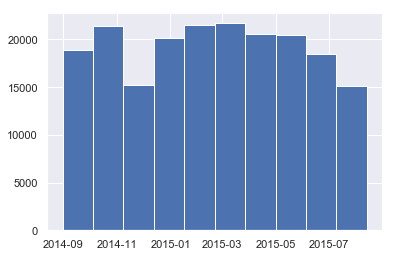

In [4]:
basket_time.head()
basket_time.describe(include = 'all')
basket_time.dtypes
basket_time.transaction_dt.hist()
# there seem to be errors in transaction_dt_local, not lining up with the dates in transaction_dt
# look to filter out anything outside of transaction_dt range

### zipcode to geopoint data

In [5]:
geo_mt.head()
geo_mt.describe()
geo_mt['Zip'] = geo_mt['Zip'].astype(str)

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,71937,Cove,AR,34.398483,-94.39398,-6,1,"34.398483, -94.39398"
1,72044,Edgemont,AR,35.624351,-92.16056,-6,1,"35.624351, -92.16056"
2,56171,Sherburn,MN,43.660847,-94.74357,-6,1,"43.660847, -94.74357"
3,49430,Lamont,MI,43.010337,-85.89754,-5,1,"43.010337, -85.89754"
4,52585,Richland,IA,41.194129,-91.98027,-6,1,"41.194129, -91.98027"


,Zip,Latitude,Longitude,Timezone,Daylight savings time flag
count,43191.000000,43191.000000,43191.000000,43191.000000,43191.000000
mean,49378.960385,38.502966,-90.937937,-5.842143,0.959482
std,27953.625723,5.395779,15.356758,1.016485,0.197172
min,210.000000,-7.209975,-176.636750,-10.000000,0.000000
25%,25840.500000,35.017504,-97.245800,-6.000000,1.000000
50%,48654.000000,39.130404,-87.830520,-6.000000,1.000000
75%,72740.500000,41.879019,-80.057185,-5.000000,1.000000
max,99950.000000,71.299525,-64.734694,-4.000000,1.000000


### store_id & geopoint matchtable

In [6]:
store_id_loc = receipt_df[['store_geo_store_id','store_geo_longitude','store_geo_latitude']].drop_duplicates().dropna()
# make sure each id matches up to one geopoint
store_id_loc.groupby('store_geo_store_id').count().max()
# change IDs to strings
store_id_loc['store_geo_store_id'] = store_id_loc['store_geo_store_id'].astype(str)
# remove whitespace
store_id_loc = store_id_loc.apply(lambda x: x.replace(r'^\s+$', np.nan, regex=True) if x.dtype == "object" else x)
store_id_loc = store_id_loc.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
# change geopoint to numeric
store_id_loc[['store_geo_longitude','store_geo_latitude']] = store_id_loc[['store_geo_longitude','store_geo_latitude']].apply(pd.to_numeric)

store_geo_longitude    1
store_geo_latitude     1
dtype: int64

# Data Cleaning for basket timeseries dataset

In [7]:
# check each basket has exactly one timestamp
basket_time_uniques = basket_time.groupby('basket_id').count().reset_index()
basket_time_uniques.head()
# there are baskets w/o timestamps
basket_time_uniques.transaction_dt_local.value_counts()
# filter for only one timestamped observations
basket_time_valid = basket_time_uniques[basket_time_uniques.transaction_dt_local == 1]
basket_time_valid.head()
basket_time_final = basket_time.loc[basket_time['basket_id'].isin(basket_time_valid.basket_id)]
basket_time_final['basket_id'] = basket_time_final['basket_id'].astype(str)
basket_time_final.head()

,basket_id,transaction_dt,transaction_dt_local
0,22856327,1,1
1,22858233,1,1
2,22882971,1,1
3,22883015,1,1
4,22888904,1,1


1    181574
0     11823
4        20
Name: transaction_dt_local, dtype: int64

,basket_id,transaction_dt,transaction_dt_local
0,22856327,1,1
1,22858233,1,1
2,22882971,1,1
3,22883015,1,1
4,22888904,1,1


/Users/joopark1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,basket_id,transaction_dt,transaction_dt_local
0,22905646,2014-08-31,2014-08-31 11:10:00
1,22927041,2014-08-31,2014-08-31 14:39:00
2,22930964,2014-08-31,2014-08-31 14:59:00
3,22935152,2014-08-31,2014-08-31 12:37:00
4,22942098,2014-08-31,2014-08-31 15:29:00


# Data Cleaning for the main dataset

### Basic data cleanup

In [8]:
# drop any duplicates
receipt_df_clean = receipt_df.drop_duplicates()

In [9]:
# strip any whitespace in string features
receipt_df_clean = receipt_df_clean.apply(lambda x: x.replace(r'^\s+$', np.nan, regex=True) if x.dtype == "object" else x)
receipt_df_clean = receipt_df_clean.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
# convert 'unknown' to blanks
receipt_df_clean = receipt_df_clean.replace(['','unknown'], np.nan)

In [10]:
# data type change: to numeric
object_to_numeric = ['store_geo_latitude', 'store_geo_longitude','trip_rating']
receipt_df_clean[object_to_numeric] = receipt_df_clean[object_to_numeric].apply(pd.to_numeric)

# unpack binned numeric features with reasonable average values
receipt_df_clean.user_demo_age.unique()
receipt_df_clean.user_demo_income.unique()
receipt_df_clean['user_demo_age'] = receipt_df_clean['user_demo_age'].replace(to_replace = {'18-20':19.0, '21-24':22.5, '25-34': 30.0, '35-44':40.0, '45-54':50.0, '55-64':60.0, '65+':70.0})
receipt_df_clean['user_demo_income'] = receipt_df_clean['user_demo_income'].replace(to_replace = {'- $20k':10, '$20k-40k':30, '$40k-60k':50, '$60k-80k':70, '$80k-100k':90, '$100k-125k':113, '$125k +':170})

array(['25-34', '35-44', '55-64', '45-54', '18-20', '65+', nan, '21-24'],
      dtype=object)

array(['$100k-125k', '$60k-80k', nan, '- $20k', '$125k +', '$80k-100k',
       '$40k-60k', '$20k-40k'], dtype=object)

In [11]:
# data type change: to object
numeric_to_object = ['user_id', 'basket_id', 'user_geo_postal_code', 'store_geo_store_id']
receipt_df_clean[numeric_to_object] = receipt_df_clean[numeric_to_object].astype(str)


In [12]:
# filter for observations in valid basket_id
receipt_df_clean = receipt_df_clean[receipt_df_clean.basket_id.isin(basket_time_final.basket_id)]

In [13]:
# filter out non-Californian residents, considering case suggests the dataset should only contain CA based users
receipt_df_clean = receipt_df_clean[receipt_df_clean.user_geo_state == 'CA']

### Feature trim

In [14]:
# check missing value percentage for each feature
receipt_df_clean.isnull().sum() / len(receipt_df_clean)

user_id                                          0.000000
basket_id                                        0.000000
banner_name                                      0.000107
retailer_name                                    0.000124
channel_name                                     0.000000
parent_channel_name                              0.000000
user_geo_postal_code                             0.000000
user_geo_city                                    0.000000
user_geo_rural_code                              0.000000
user_geo_state                                   0.000000
user_geo_census_region                           0.000000
user_geo_census_division                         0.000000
store_geo_store_id                               0.000000
store_geo_store_name                             0.699777
store_geo_latitude                               0.560694
store_geo_longitude                              0.560694
store_geo_state                                  0.560694
store_geo_city

In [15]:
# features to drop
features_too_many_nulls_or_uniform = ['user_demo_employment','user_geo_state','user_geo_census_region','user_geo_census_division','user_demo_household_size', 'store_geo_state','store_geo_city','store_geo_longitude','store_geo_latitude','store_geo_store_name']
superfluous_features = ['parent_channel_name','payment_id','last_update','transcribed','transcription_level','were_there_other_stores_on_this_shopping_trip']
# drop features
receipt_df_lean = receipt_df_clean.drop(columns= features_too_many_nulls_or_uniform + superfluous_features)

In [16]:
# lean dataset
receipt_df_lean.head()

,user_id,basket_id,banner_name,retailer_name,channel_name,user_geo_postal_code,user_geo_city,user_geo_rural_code,store_geo_store_id,payment_method,trip_type,basket_total_dollars,basket_total_units,salestax,user_demo_ethnicity,user_demo_age,user_demo_education,user_demo_gender,user_demo_has_children_under17,user_demo_income,user_demo_marital_status,trip_rating,kids_present_on_trip,adult_genders_on_trip,other_banners_in_shopping_trip,other_retailers_in_shopping_trip,location_during_the_shopping_trip
0,125436,22858233,Walmart,Walmart,Mass,94305,Stanford,Urban,1200069,NaN,Express Lane (3-10 Items),16.80,10,0.17,White or Caucasian,30.0,Advanced degree,Female,No,113.0,Married,NaN,NaN,NaN,Walmart,Walmart,Only Stop
1,24401,22883015,Vons,Safeway,Food,92883,Corona,Suburban,0,NaN,Express Lane (3-10 Items),47.28,3,0.00,White or Caucasian,40.0,Advanced degree,Female,Yes,70.0,Married,NaN,NaN,NaN,"Target, Vons","Target, Safeway",Last Stop
3,623415,22912171,RiteAid,RiteAid,Drug,93270,Terra Bella,Rural,1504646,CASH,Express Lane (3-10 Items),9.30,3,0.65,White or Caucasian,30.0,Some college or university,Female,Yes,10.0,Divorced,NaN,NaN,NaN,RiteAid,RiteAid,Only Stop
4,319170,22912271,Vons,Safeway,Food,93021,Moorpark,Suburban,1332228,CASH,Express Lane (3-10 Items),18.19,9,0.00,White or Caucasian,40.0,College graduate with a 4 year degree,Female,Yes,170.0,Married,100.0,No Kids,Male Adult Only,Vons,Safeway,Only Stop
5,549578,22912771,Walmart,Walmart,Mass,92223,Beaumont,Suburban,1204629,CREDIT,Fill Up (11-20 Items),38.87,13,NaN,White or Caucasian,60.0,College graduate with a 2 year degree,Female,No,NaN,Married,100.0,No Kids,Male and Female Adult on trip,Walmart,Walmart,Only Stop


In [17]:
receipt_df_filtered = receipt_df_lean

### Filtering out troublesome observations

In [18]:
# attaching basket timestamp info for time-based filtering
receipt_df_filtered = pd.merge(receipt_df_filtered, basket_time_final, how = 'left', on = 'basket_id')

In [19]:
# check timestamp info
receipt_df_filtered.transaction_dt.describe()
receipt_df_filtered.transaction_dt_local.describe()

count                  177398
unique                    348
top       2015-04-04 00:00:00
freq                      821
first     2014-08-31 00:00:00
last      2015-08-13 00:00:00
Name: transaction_dt, dtype: object

count                  177398
unique                 139117
top       2015-05-08 17:40:00
freq                        7
first     2004-10-15 21:42:32
last      2015-12-05 10:20:01
Name: transaction_dt_local, dtype: object

In [20]:
# filter out out-of-range transactions, considering case suggests the dataset should only contain 1 year worth of data
receipt_df_filtered = receipt_df_filtered[receipt_df_filtered['transaction_dt_local'] >= receipt_df_filtered.transaction_dt.min()]
receipt_df_filtered = receipt_df_filtered[receipt_df_filtered['transaction_dt_local'] <= (receipt_df_filtered.transaction_dt.max() + timedelta(days=1))]

In [21]:
# filter out observations with suspicious timestamps
receipt_df_filtered = receipt_df_filtered[(receipt_df_filtered['transaction_dt'] < receipt_df_filtered['transaction_dt_local'])]

In [22]:
# check for duplicates and null observations one more time
receipt_df_filtered = receipt_df_filtered.drop_duplicates()
receipt_df_filtered = receipt_df_filtered.dropna(how = 'all')

In [23]:
# remove observations with only one trip information --> doesn't give sequential shopping info for prediction model
user_observation_counts = receipt_df_filtered.groupby('user_id').count()['basket_id'].reset_index()
user_singular_observation = user_observation_counts[user_observation_counts['basket_id'] == 1]
receipt_df_filtered = receipt_df_filtered[~receipt_df_filtered['user_id'].isin(user_singular_observation['user_id'])]

In [24]:
# filter out shopping observations where retailer appears less than 30 times in the data
retailers_to_keep = pd.DataFrame(receipt_df_filtered.retailer_name.value_counts()>30).reset_index()
retailers_to_keep.columns = ['retailer_name','more_than_30']
retailers_to_keep = retailers_to_keep[retailers_to_keep.more_than_30 == True]
receipt_df_filtered = receipt_df_filtered[receipt_df_filtered.retailer_name.isin(retailers_to_keep.retailer_name)]

# Feature Engineering

In [25]:
# add in lat/long centroid of user zipcode for geospatial info
receipt_df_engineered = pd.merge(receipt_df_filtered, geo_mt[['Zip', 'Latitude', 'Longitude']], how = 'left', left_on = 'user_geo_postal_code', right_on = 'Zip')
receipt_df_engineered = receipt_df_engineered.drop(columns=['Zip']).rename(columns={"Latitude": "user_home_lat", "Longitude": "user_home_long"})

In [26]:
# # add in lat/long of store_ids -- not realistic due to too many missing values (56% of obs missing)
# receipt_df_engineered = pd.merge(receipt_df_engineered, store_id_loc, how = 'left')
# receipt_df_engineered[['store_geo_longitude','store_geo_latitude', 'user_home_lat','user_home_long']].describe(include='all')

In [27]:
# sort by user_id and timestamp
receipt_df_engineered = receipt_df_engineered.sort_values(by = ['user_id', 'transaction_dt_local'], ascending = True)

In [28]:
# extract day of week info for shopping stop
receipt_df_engineered['day_of_week'] = receipt_df_engineered.transaction_dt.dt.dayofweek.astype(str)

In [29]:
# calculate days passed since last shopping stop
receipt_df_engineered['days_since_last_stop'] = receipt_df_engineered.groupby(['user_id'])['transaction_dt'].diff().dt.days

In [30]:
# indicator if a visit had sales tax
receipt_df_engineered['has_sales_tax'] = receipt_df_engineered.salestax > 0

In [31]:
# indicator if the stop was part of a multi-stop trip
receipt_df_engineered['multi_stop'] = receipt_df_engineered.apply(lambda x: x.location_during_the_shopping_trip in ['First Stop','Middle Stop','Last Stop'], axis = 1)

In [32]:
# replace any blanks with NaN
receipt_df_engineered = receipt_df_engineered.replace(['',None], np.nan)

In [33]:
# create lag features: previous shopping stop information
lag_features = ['user_id','payment_method','multi_stop','retailer_name','channel_name','basket_total_dollars','basket_total_units', 'location_during_the_shopping_trip','trip_rating','has_sales_tax']
receipt_df_engineered = receipt_df_engineered.sort_values(by = ['user_id', 'transaction_dt_local'], ascending = True)
lagged_df = receipt_df_engineered[lag_features].groupby('user_id').shift()

for feature in lag_features[1:]:
    new_name = 'previous_'+feature
    receipt_df_engineered[new_name] = lagged_df[feature]

#### omit this section -- takes too long computationally

In [34]:
# # cumulative count of each day's shopping trip stops upto the previous stop of each day
# user_daily_stops_count = pd.get_dummies(receipt_df_engineered[['retailer_name']], prefix='', prefix_sep='')
# user_daily_stops_count = pd.concat([user_daily_stops_count, receipt_df_engineered[['user_id','transaction_dt_local','transaction_dt']]], axis=1)
# user_daily_stops_count = user_daily_stops_count.sort_values(by=['user_id','transaction_dt_local'], ascending=True).drop(columns = 'transaction_dt_local')

In [35]:
# user_daily_stops_count_skeleton = pd.DataFrame()
# for retailer in user_daily_stops_count.columns:
#     user_daily_stops_count_skeleton[retailer] = user_daily_stops_count.groupby(['user_id','transaction_dt'])[retailer].transform(lambda x: x.cumsum().shift())
# user_daily_stops_count_final = user_daily_stops_count_skeleton.replace(np.nan, 0)

In [36]:
# # append cumulative counts to the main dataset
# receipt_df_engineered_final = pd.concat([receipt_df_engineered, user_daily_stops_count_final], axis=1)

In [37]:
receipt_df_engineered_final = receipt_df_engineered

### Creating modeling dataframe

In [204]:
# select modeling features -- user details & current shopping situation details & previous stop's shopping details
target_feature = ['retailer_name']
current_stop_features = ['user_id','day_of_week','days_since_last_stop','user_geo_city','user_geo_rural_code',\
                     'user_demo_ethnicity', 'user_demo_age',\
                     'user_demo_education','user_demo_gender', 'user_demo_has_children_under17', 'user_demo_income',\
                     'user_demo_marital_status', 'kids_present_on_trip', 'adult_genders_on_trip',\
                         'location_during_the_shopping_trip','multi_stop']
previous_stop_features = ['previous_retailer_name', 'previous_channel_name',\
                          'previous_basket_total_dollars',\
                          'previous_basket_total_units','previous_location_during_the_shopping_trip',\
                          'previous_multi_stop','previous_trip_rating','previous_payment_method','previous_has_sales_tax']
# cumulative_shopping_count_feature = user_daily_stops_count_final.columns.tolist()
modeling_features = []
modeling_features.extend(target_feature)
modeling_features.extend(current_stop_features)
modeling_features.extend(previous_stop_features)
# modeling_features.extend(cumulative_shopping_count_feature)
modeling_df = receipt_df_engineered_final[modeling_features]

In [205]:
# BEFORE SHOPPING PREDICTION MODELING: remove first observation for each user since it does not have prior observation
modeling_df = modeling_df.groupby('user_id', group_keys=False).apply(lambda x:x.iloc[1:])

In [206]:
modeling_df = modeling_df.apply(lambda x: x.astype(str) if x.dtype == "object" else x)


# receipt_df_clean = receipt_df_clean.apply(lambda x: x.replace(r'^\s+$', np.nan, regex=True) if x.dtype == "object" else x)
# receipt_df_clean = receipt_df_clean.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Main Model for Retailer Prediction -- used for Questions 2 & 5

In [207]:
modeling_df.head()

,retailer_name,user_id,day_of_week,days_since_last_stop,user_geo_city,user_geo_rural_code,user_demo_ethnicity,user_demo_age,user_demo_education,user_demo_gender,user_demo_has_children_under17,user_demo_income,user_demo_marital_status,kids_present_on_trip,adult_genders_on_trip,location_during_the_shopping_trip,multi_stop,previous_retailer_name,previous_channel_name,previous_basket_total_dollars,previous_basket_total_units,previous_location_during_the_shopping_trip,previous_multi_stop,previous_trip_rating,previous_payment_method,previous_has_sales_tax
18207,Smart & Final,100028,6,23.0,North Hills,Urban,Hispanic or Latino,30.0,Advanced degree,Male,No,90.0,Married,No Kids,Male Adult Only,First Stop,True,Smart & Final,Club,41.38,26.0,First Stop,True,60.0,CASH,False
23801,Kroger,100028,6,0.0,North Hills,Urban,Hispanic or Latino,30.0,Advanced degree,Male,No,90.0,Married,No Kids,Male Adult Only,Last Stop,True,Smart & Final,Club,32.07,13.0,First Stop,True,60.0,DEBIT,False
18822,Kroger,100028,5,6.0,North Hills,Urban,Hispanic or Latino,30.0,Advanced degree,Male,No,90.0,Married,No Kids,Male Adult Only,First Stop,True,Kroger,Food,8.80,3.0,Last Stop,True,60.0,CREDIT,True
53866,Walmart,100028,2,81.0,North Hills,Urban,Hispanic or Latino,30.0,Advanced degree,Male,No,90.0,Married,No Kids,Female Adult Only,Only Stop,False,Kroger,Food,109.02,30.0,First Stop,True,60.0,DEBIT,True
72203,Smart & Final,100028,2,21.0,North Hills,Urban,Hispanic or Latino,30.0,Advanced degree,Male,No,90.0,Married,No Kids,Male Adult Only,First Stop,True,Walmart,Mass,42.98,12.0,Only Stop,False,60.0,DEBIT,True


In [208]:
modeling_df.isnull().sum() / len(modeling_df)

retailer_name                                 0.000000
user_id                                       0.000000
day_of_week                                   0.000000
days_since_last_stop                          0.000000
user_geo_city                                 0.000000
user_geo_rural_code                           0.000000
user_demo_ethnicity                           0.000000
user_demo_age                                 0.049353
user_demo_education                           0.000000
user_demo_gender                              0.000000
user_demo_has_children_under17                0.000000
user_demo_income                              0.181246
user_demo_marital_status                      0.000000
kids_present_on_trip                          0.000000
adult_genders_on_trip                         0.000000
location_during_the_shopping_trip             0.000000
multi_stop                                    0.000000
previous_retailer_name                        0.000000
previous_c

In [209]:
# preprocessing df
# lb = LabelBinarizer() -- no need to do this since we're using RF as our estimator, which can take in multi-class feature
rf_imputer = SimpleImputer(strategy='median')

X_obj = modeling_df.drop(columns='retailer_name').select_dtypes(include='object')
X_non_obj = modeling_df.drop(columns='retailer_name').select_dtypes(exclude='object')

X_obj_transformed = pd.get_dummies(X_obj)
rf_imputer.fit(X_non_obj)
X_non_obj_imputed = pd.DataFrame(data=rf_imputer.transform(X_non_obj), columns=X_non_obj.columns)
X_transformed = pd.concat([X_non_obj_imputed.reset_index(), X_obj_transformed.reset_index()], axis=1).drop(columns='index')
# Y_transformed = lb.fit_transform(modeling_df[target_feature])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [210]:
X_transformed.shape

(170547, 3457)

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, modeling_df['retailer_name'], random_state=0)

# init models
pca = PCA(random_state=0)
# had to limit to this fit due to limited compute power..could not do the pipeline/gridsearch/CV as I had hoped
rf = RandomForestClassifier(n_estimators=50, random_state=0) 

# hyperparameter grid
# param_grid = {'pca__n_components': [50,100,150],
#               'rf__n_estimators': [50,100,150]}

# param_grid = {'n_estimators': [50]}
# pipeline
# pca_rf_model = Pipeline(steps=[('rf', rf)])
# search
# grid = GridSearchCV(rf, param_grid)

# grid.fit(X_train, Y_train)
rf.fit(X_train, Y_train)

# best model parameters
# rf.best_params_
# best model
# model = grid.best_estimator_

Y_predicted = rf.predict(X_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

0.17694497554713667

Text(0.5,12.5,'true retailer')

Text(89.18,0.5,'predicted retailer')

/Users/joopark1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joopark1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joopark1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                  precision    recall  f1-score   support

                        7-Eleven       0.37      0.27      0.31       585
                   99 Cents Only       0.21      0.13      0.16      1006
                 99 Ranch Market       0.20      0.09      0.12       163
                    A. C. Market       0.42      0.80      0.55        10
                           AAFES       0.00      0.00      0.00         5
                           Ahold       0.00      0.00      0.00         9
                      Albertsons       0.40      0.39      0.40      1935
               Andronicos Market       0.67      0.25      0.36         8
                            Arco       0.38      0.19      0.25       221
                  Bel Air Market       0.33      0.37      0.35       233
                 Big Saver Foods       0.17      0.15      0.16        26
                   Bodega Latina       0.07      0.04      0.05        85
                   Bristol Farms     

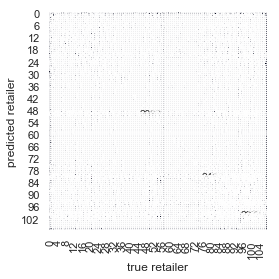

In [49]:
# model scoring -- poor performance..likely would have been able to improve with grid search and more compute power
# class imbalance probably also contributed to low balanced accuracy
balanced_accuracy_score(Y_test, Y_predicted)

confusion_X = confusion_matrix(Y_test, Y_predicted)
sns.heatmap(confusion_X.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true retailer')
plt.ylabel('predicted retailer');

print(classification_report(Y_test, Y_predicted))

# Answering the Questions

### 1. Are there any additional input variables we could provide to improve your model? What are they, and why?

In [ ]:
# weather data for the shopping trip to layer in how weather influences shopping location choices
# better labeled geo location for the stores (nearly half was not defined)
# traffic data for the time and location
# where the shopper came from for each shopping stop -- data on how far they travel for the stop
# mode of transportation -- may influence where

### 2. What are the most/least important features that explain the likelihood of retailer visits?

In [192]:
rf_feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
rf_feature_importances
rf_feature_importances['importance'].describe()

,importance
previous_basket_total_dollars,5.437227e-02
previous_basket_total_units,5.014352e-02
days_since_last_stop,4.292854e-02
previous_trip_rating,2.290460e-02
user_demo_income,1.957154e-02
user_demo_age,1.686069e-02
previous_has_sales_tax_False,1.574048e-02
previous_has_sales_tax_True,1.559040e-02
day_of_week_5,1.373274e-02
day_of_week_6,1.350000e-02


count    3457.000000
mean        0.000289
std         0.001952
min         0.000000
25%         0.000022
50%         0.000047
75%         0.000087
max         0.054372
Name: importance, dtype: float64

### 3. For Hispanic Walmart shoppers, which other retailers are they most likely to shop at?

In [193]:
# extract user_id for users who shop at Walmart
hispanic_wm_shoppers = set(modeling_df[modeling_df.retailer_name == 'Walmart'].user_id)
# shopping data for the above users
hispanic_wm_shopping_obs = modeling_df[modeling_df.user_id.isin(hispanic_wm_shoppers)]
# score each user on visitation distribution
hispanic_wm_shopper_counts = hispanic_wm_shopping_obs.groupby(['user_id','retailer_name'],as_index=False).count()
hispanic_wm_shopper_counts = hispanic_wm_shopper_counts[['user_id','retailer_name','day_of_week']].rename(columns={'day_of_week':'visits'})
hispanic_wm_shopper_scores = hispanic_wm_shopper_counts.groupby(['user_id'])['visits'].apply(lambda x: 100 * x / float(x.sum()))
hispanic_wm_shopper_scores = pd.concat([hispanic_wm_shopper_scores,hispanic_wm_shopper_counts['retailer_name']], axis =1)
hispanic_wm_retailer_scores = hispanic_wm_shopper_scores.groupby(['retailer_name']).mean().reset_index().rename(columns={'visits':'score'})
hispanic_wm_retailer_scores = hispanic_wm_retailer_scores.sort_values(by='score',ascending=False)

In [121]:
# averaged proportion of retailer visits of Hispanic Walmart shoppers
hispanic_wm_retailer_scores

,retailer_name,score
3,A. C. Market,39.495798
99,Walmart,17.341694
50,Kroger,15.805550
80,Safeway,14.733654
88,Stater Bros.,14.626830
18,Commissary,14.530355
93,Target,14.419174
97,Verdugo Market,14.053319
19,Cost Less Foods,12.908483
21,Costco,11.742999


### 4. Among Dollar General shoppers, which shopper group(s) are most likely to visit, and how do they look different than other shopper group(s)? -- logistic regression

In [211]:
# creating the dataset
modeling_df4 = modeling_df
# extract user_id for users who shop at DG
dg_shoppers = set(modeling_df4[modeling_df4.retailer_name == 'Dollar General'].user_id)

In [212]:
# indicator if user is DG shopper
modeling_df4['dg_shopper'] = modeling_df4.user_id.isin(dg_shoppers)

# user-level data with relevant characteristics
target_feature4 = ['dg_shopper']
characteristics = ['day_of_week','days_since_last_stop','user_geo_city','user_geo_rural_code',\
                     'user_demo_ethnicity', 'user_demo_age',\
                     'user_demo_education','user_demo_gender', 'user_demo_has_children_under17', 'user_demo_income',\
                     'user_demo_marital_status', 'kids_present_on_trip', 'adult_genders_on_trip','multi_stop']
modeling_df4 = modeling_df4[target_feature4+characteristics]

In [213]:
# preprocessing df
X_obj4 = modeling_df4.drop(columns='dg_shopper').select_dtypes(include='object')
X_non_obj4 = modeling_df4.drop(columns='dg_shopper').select_dtypes(exclude='object')
# one hot encoding
X_obj_transformed4 = pd.get_dummies(X_obj4)

lr_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
# scaling and imputing
X_non_obj_imputed4 = pd.DataFrame(data=scaler.fit_transform(lr_imputer.fit_transform(X_non_obj4)), columns=X_non_obj4.columns)

X_transformed4 = pd.concat([X_non_obj_imputed4.reset_index(), X_obj_transformed4.reset_index()], axis=1).drop(columns='index')

In [76]:
# fit logistic regression model -- great explainability of features
X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X_transformed4, modeling_df4['dg_shopper'], random_state=0)

# init model
lr = LogisticRegression(random_state=0, max_iter=200)

# hyperparameter grid
lr_param_grid = {'penalty': ['l2', 'elasticnet'],
                 'fit_intercept': [False,True]}

# search
lr_grid = GridSearchCV(lr, lr_param_grid)

lr_grid.fit(X_train4, Y_train4)

# best model parameters
lr_grid.best_params_
# best model
lr_model = lr_grid.best_estimator_

Y_predicted4 = lr_model.predict(X_test4)

/Users/joopark1/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/joopark1/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [False, True],
                         'penalty': ['l2', 'elasticnet']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

{'fit_intercept': True, 'penalty': 'l2'}

0.7027983030451257

Text(0.5,12.5,'true DG shopper')

Text(89.18,0.5,'predicted DG shopper')

              precision    recall  f1-score   support

       False       0.96      0.99      0.98     39998
        True       0.76      0.41      0.54      2639

    accuracy                           0.96     42637
   macro avg       0.86      0.70      0.76     42637
weighted avg       0.95      0.96      0.95     42637



0.7027983030451257

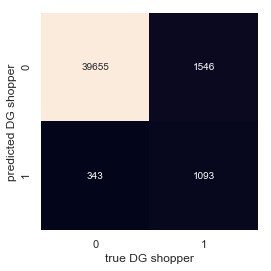

In [77]:
# model scoring -- lot of false negatives
balanced_accuracy_score(Y_test4, Y_predicted4)

confusion_X4 = confusion_matrix(Y_test4, Y_predicted4)
sns.heatmap(confusion_X4.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true DG shopper')
plt.ylabel('predicted DG shopper');

print(classification_report(Y_test4, Y_predicted4))

roc_auc_score(Y_test4, Y_predicted4)

In [139]:
# extract defining characterstics of DG shoppers
lr_coefficients = pd.concat([pd.DataFrame(X_train4.columns),pd.DataFrame(np.transpose(lr_model.coef_))], axis = 1)
lr_coefficients.columns = ['feature','coefficient']
lr_coefficients['direction'] = lr_coefficients.coefficient.apply(lambda x: 'positive' if x >0 else 'negative')
lr_coefficients['coefficient'] = abs(lr_coefficients.coefficient)
lr_coefficients = lr_coefficients.sort_values(by='coefficient', ascending=False)
lr_coefficients_city_feature = lr_coefficients[lr_coefficients.feature.str.contains('user_geo_city')]
lr_coefficients_non_city_features = lr_coefficients[~lr_coefficients.feature.str.contains('user_geo_city')]

In [240]:
lr_coefficients_non_city_features.feature[673]

'adult_genders_on_trip_Male and Female Adult on trip'

### 5. How would Safeway shoppers and/or other retailers be impacted if Safeway were to close their stores?

In [214]:
# where would Safeway shoppers go instead of Safeway was no longer available?
# look at observations where Safeway visit is predicted and extract the second highest probable retailer
# use the random forest model built to predict retailer visits

# creating the dataset of Safeway shoppers
modeling_df5 = modeling_df
# extract user_id for users who shop at DG
sw_shoppers = set(modeling_df5[modeling_df5.retailer_name == 'Safeway'].user_id)

In [215]:
# transformed observations of Safeway shoppers ready for RF model
X_transformed5 = X_transformed[X_obj.reset_index().user_id.isin(sw_shoppers)]

In [218]:
# predict shopping of Safeway shoppers
sw_shopper_predict = rf.predict_proba(X_transformed5)

In [228]:
sw_prediction = pd.DataFrame(columns= rf.classes_, data = sw_shopper_predict)

# extract top 2 most probable retailers
nlargest = 2
order = np.argsort(-sw_prediction.values, axis=1)[:, :nlargest]
result = pd.DataFrame(sw_prediction.columns[order], 
                      columns=['top{}'.format(i) for i in range(1, nlargest+1)],
                      index=sw_prediction.index)

In [241]:
# find their "second choice" retailer likelihoods
safeway_bound_obs = result[result.top1 == 'Safeway']
safeway_replacement = safeway_bound_obs.top2.value_counts(ascending=False)/safeway_bound_obs.top2.value_counts().sum()
safeway_replacement

Target                              0.221810
Walmart                             0.138120
Costco                              0.112998
Kroger                              0.088258
Trader Joe's                        0.068608
Walgreens                           0.047531
CVS                                 0.037872
Albertsons                          0.026120
Winco Foods                         0.023075
Stater Bros.                        0.021410
Dollar Tree                         0.021220
RiteAid                             0.016938
Lucky                               0.016510
Raley's                             0.015082
Food Maxx                           0.013369
99 Cents Only                       0.013179
Sprouts Farmers Market              0.011704
Sam's Club                          0.011181
7-Eleven                            0.010182
Smart & Final                       0.010134
Grocery Outlet                      0.009849
Whole Foods                         0.008707
Fresh & Ea